### MNIST dataset
The dataset contains 70.000 images of handwritten digits. The images come pre-labeled. 
Each image has $28 \times 28$ pixels and therefore has $784$ features. 

The MNIST dataset has the fantastic feature that it already contains predefined training and test datasets. 

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We will show one of the digits.

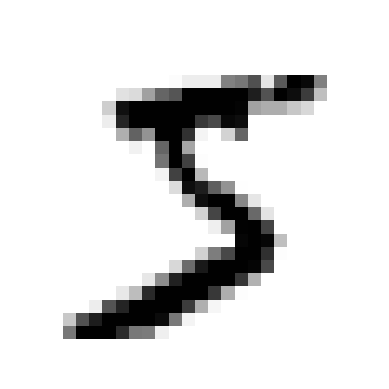

In [10]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [5]:
y[0]

'5'

As mentioned in the beginning the data is already split into a test and a training set. The data is shuffled which is important as it ensures that all cross-validation folds will be similar. Some ML algorithms are also sensitive to the order of the training instances and perform poorly if there are many similar ones in a row. 

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary classifier
We'll start out by finding one digit. In this case the number five. It's called a binary classifier because it only will be capable of distinguishing two classes.

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Well start out with a stochastic gradient descent (SGD) classifier.

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

### Performance measures
It is harder to evaluate classifier than a regressor.

#### Measuring accuracy using cross-validation
Like with linear regressors it can be useful to use cross-validation. For this cross_val_score() will be used on the previous classifier.

We are using k-fold cross-validation which means we split the data into k folds then training the model this amount of times evaluating against different folds each time. 

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

The high accuracy of the model is because only 10% of the images are pictures of a five. This means that guessing something isn't a five has a 90% accuracy as a baseline. This also illustrates why accuracy is not the preferred metric when dealing with classifiers. This also goes when working with skewed datasets - i.e. datasets that have classes with significantly higher frequency than others. We will look at using Confusion Matrices instead.

#### Confusion matrix
As remembered from our good old remote sensing classes the confusion matrix counts the number of times class A are classified as class B for all A/B pairs. 
To use a confusion matrix we first need to have some predictions.

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like before this method validates with k-fold cross-validation - but returns the predictions instead of the evaluation scores. 

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row here is an actual class and each column a predicted class.

$$
\def\arraystretch{1.5}
   \begin{array}{c:c:c}
   53892 & 687 \\
   \hdashline
   1891 & 3530 \\
\end{array}, 
\def\arraystretch{1.5}
   \begin{array}{c:c:c}
    & \textit{actually positive} & \textit{actually negative} \\ \hline
   \textit{predicted positive} & \textit{negative class} & \textit{false positives (type I error)}\\
   \hdashline
   \textit{predicted negative} & \textit{positive class} & \textit{flase negatives (type II eror)}
\end{array}
$$

Of the non 5's 53892 were correctly classified as not being 5's. 687 were wrongly classified as being 5's.
Of the 5's 1891 were wrongly classified and 3530 were correctly classified as 5's. In a perfect world where there were no false negatives and false positives only the main diagonal would have non-zero values. 

The precision (or accuracy) of the classifier is defined as:

$$
\text{precision} = \frac{TP}{TP+FP}
$$

But this hardly ever stands alone. Precision is usually reported alongside recall - aka sensitivity of the true positive rate. The ratio of positive instances correctly detected by the classifier.

$$
\text{recall} = \frac{TP}{TP+FN}
$$

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

These scores can be combined into the $F_1$ score. This score is the harmonic mean - a mean value that gives more weight to low values

$$
F_1 = \frac{TP}{TP + \frac{FN+FP}{2}}
$$

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_1$ score favors similar precision and recall. This is not always wanted though.

#### The receiver operating characteristic